# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [88]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn import decomposition
from sklearn.model_selection import StratifiedKFold

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from scipy import interp

from tqdm import tqdm
import os
import time

In [89]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (10000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [90]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [91]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [92]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [93]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [94]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [95]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [96]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9564, 10)

In [97]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.64

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [98]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [99]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [100]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(9564, 10)


1    7976
0    1588
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [101]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
15 month old loves to eat them on the go! They seem great for a healthy, quick, and easy snack!
These chips are truly amazing. They have it all. They're light, crisp, great tasting, nice texture, AND they're all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and couldn't belive my taste buds. That's why I excited why I saw them here on Amazon, and decided to buy a case!
These tablets definitely made things sweeter -- like lemons, limes, and grapefruit.  But it wasn't to the point of sheer amazement.  They also had an interesting effect on cheeses and vinegar, but still did virtually nothing for beer and wine. The tablets are a bit pricey but they do work.  If you've got extra money, sure, give them a try, but if you're looking for some amazing way to get your kids to eat broccoli or something along those lines then this is not the answer. F

In [102]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [103]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
15 month old loves to eat them on the go! They seem great for a healthy, quick, and easy snack!
These chips are truly amazing. They have it all. They're light, crisp, great tasting, nice texture, AND they're all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and couldn't belive my taste buds. That's why I excited why I saw them here on Amazon, and decided to buy a case!
These tablets definitely made things sweeter -- like lemons, limes, and grapefruit.  But it wasn't to the point of sheer amazement.  They also had an interesting effect on cheeses and vinegar, but still did virtually nothing for beer and wine. The tablets are a bit pricey but they do work.  If you've got extra money, sure, give them a try, but if you're looking for some amazing way to get your kids to eat broccoli or something along those lines then this is not the answer. F

In [104]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [105]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

These chips are truly amazing. They have it all. They are light, crisp, great tasting, nice texture, AND they are all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and could not belive my taste buds. That is why I excited why I saw them here on Amazon, and decided to buy a case!


In [106]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [107]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

These chips are truly amazing They have it all They are light crisp great tasting nice texture AND they are all natural AND low in fat and sodium Need I say more I recently bought a bag of them at a regular grocery store and could not belive my taste buds That is why I excited why I saw them here on Amazon and decided to buy a case 


In [108]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

## Time based splitting
* Sort the data based on `Time` column
* Get the 80% data for train and 20% data on test

In [109]:
# time based splitting for a dataframe
def split_time_based(df, time_col, train_perc):
    if type(df).__name__ != 'DataFrame':
        print("Please provide a dataframe!")
    if type(time_col).__name__ != 'list':
        print("Please porvide the time column as list")
    # Sort the dataframe based on time column
    df.sort_values(by=time_col, inplace=True)
    df_row, df_col = df.shape
    train_row = round(df_row * (train_perc/100))
    test_row = df_row - train_row
    return df.head(train_row), df.tail(test_row)

In [110]:
# Splitting the data based on Time column, where train=80% and test=20%
final_train, final_test = split_time_based(final, ['Time'], 80)
print(final_train.shape)
print(final_test.shape)

(7651, 10)
(1913, 10)


In [111]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews_train = []
# tqdm is for printing the status bar
for sentance in tqdm(final_train['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_train.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 7651/7651 [00:03<00:00, 2042.99it/s]


In [112]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews_test = []
# tqdm is for printing the status bar
for sentance in tqdm(final_test['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_test.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 1913/1913 [00:00<00:00, 2159.58it/s]


In [113]:
print("Train: ",len(preprocessed_reviews_train))
print("Test: ",len(preprocessed_reviews_test))

Train:  7651
Test:  1913


In [114]:
y_train = final_train['Score']
y_test = final_test['Score']

y_train = y_train.values
y_test = y_test.values

# [4] Featurization

## [4.1] BAG OF WORDS

In [115]:
#BoW for Train data
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts_train = count_vect.transform(preprocessed_reviews_train)
print("the type of count vectorizer ",type(final_counts_train))
print("the shape of out text BOW vectorizer ",final_counts_train.get_shape())
print("the number of unique words ", final_counts_train.get_shape()[1])

some feature names  ['aa', 'aaaa', 'ab', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (7651, 16577)
the number of unique words  16577


In [116]:
#BoW for Test data
final_counts_test = count_vect.transform(preprocessed_reviews_test)
print("the type of count vectorizer ",type(final_counts_test))
print("the shape of out text BOW vectorizer ",final_counts_test.get_shape())
print("the number of unique words ", final_counts_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (1913, 16577)
the number of unique words  16577


## [4.2] TF-IDF

In [117]:
#TFIDF on Train data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf_train = tf_idf_vect.transform(preprocessed_reviews_train)
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able eat', 'able find', 'able get', 'able use', 'absolute', 'absolute best', 'absolute favorite', 'absolutely']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (7651, 4762)
the number of unique words including both unigrams and bigrams  4762


In [118]:
# TFIDF on Test data
final_tf_idf_test = tf_idf_vect.transform(preprocessed_reviews_test)
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (1913, 4762)
the number of unique words including both unigrams and bigrams  4762


## [4.3] Word2Vec

In [119]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
list_of_sentance_test=[]
for sentance in preprocessed_reviews_train:
    list_of_sentance_train.append(sentance.split())
for sentance in preprocessed_reviews_test:
    list_of_sentance_test.append(sentance.split())

# Applying to W2V model on train data
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=500, workers=4) # min count --> ignore those words having count less than 5, size --> dimensions for each word

In [120]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5033
sample words  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'printed', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'winter', 'fresh', 'blueberries', 'food', 'budget', 'dried', 'blue', 'berries', 'fine']


## [4.3.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.3.1.1] Avg W2v

In [121]:
# average Word2Vec on Train data
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(500) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 7651/7651 [00:10<00:00, 723.75it/s]


7651
500


In [122]:
# average Word2Vec on Test data
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(500) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 1913/1913 [00:02<00:00, 769.83it/s]


1913
500


#### [4.3.1.2] TFIDF weighted W2v

In [123]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [124]:
# TF-IDF weighted Word2Vec for Train data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(500) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 7651/7651 [01:12<00:00, 105.81it/s]


In [125]:
# TF-IDF weighted Word2Vec for Test data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(500) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 1913/1913 [00:15<00:00, 120.59it/s]


### Pickling the data
* Pickling the train and test data for all the implementations
* BoW
* TFIDF
* Avg-W2Vec
* TFIDF W2Vec

In [128]:
import pickle

bow_train = 'bow_train.pkl'
bow_test = 'bow_test.pkl'
tfidf_train = 'tfidf_train.pkl'
tfidf_test = 'tfidf_test.pkl'
avgw2v_train = 'avgw2v_train.pkl'
avgw2v_test = 'avgw2v_test.pkl'
tfidfw2v_train = 'tfidfw2v_train.pkl'
tfidfw2v_test = 'tfidfw2v_test.pkl'

obj1 = open(bow_train,'wb')
pickle.dump(final_counts_train, obj1)
obj1.close()

obj2 = open(bow_test,'wb')
pickle.dump(final_counts_test, obj2)
obj2.close()

obj3 = open(tfidf_train,'wb')
pickle.dump(final_tf_idf_train, obj3)
obj3.close()

obj4 = open(tfidf_test,'wb')
pickle.dump(final_tf_idf_test, obj4)
obj4.close()

obj5 = open(avgw2v_train,'wb')
pickle.dump(sent_vectors_train, obj5)
obj5.close()

obj6 = open(avgw2v_test,'wb')
pickle.dump(sent_vectors_test, obj6)
obj6.close()

obj7 = open(tfidfw2v_train,'wb')
pickle.dump(tfidf_sent_vectors_train, obj7)
obj7.close()

obj8 = open(tfidfw2v_test,'wb')
pickle.dump(tfidf_sent_vectors_test, obj8)
obj8.close()

# [5]KNN

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [39]:
# Sparse to Dense matrix
final_counts_train = final_counts_train.toarray()
final_counts_test = final_counts_test.toarray()

Applying <b>PCA</b> to reduce the dimensionality for the ease of purpose

In [40]:
#*************** Reducing dimensions drastically due to memory issue
# Applying PCA to train so that we dont have to work with high dimensions
pca = decomposition.PCA(n_components=500)
final_counts_train = pca.fit_transform(final_counts_train)
final_counts_test = pca.transform(final_counts_test)
print("Train Data shape: ",final_counts_train.shape)
print("Test Data shape: ",final_counts_test.shape)

Train Data shape:  (7651, 500)
Test Data shape:  (1913, 500)


In [41]:
# Explaned variance
information = pca.explained_variance_ratio_.cumsum()
print("After Dimension reduction we retain {}% of information.".format(round(information[-1] * 100),2))

After Dimension reduction we retain 75.0% of information.


#### Applying KNN
* Taking a range of odd neighbours as this is a binary classification.
* We have used 10 fold cross validation
* The optimum 'K' is measured from the maximum value of AUC

In [42]:
s_time = time.time()
neighbors = list(range(1,50,2)) # Creating odd number of neighbors to get the optimal k
mean_fpr = np.linspace(0, 1, 100)
area_under_roc = []
tprs = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='brute')
    cv = StratifiedKFold(n_splits=10)
    for train, test in cv.split(final_counts_train, y_train):
        proba = knn.fit(final_counts_train[train], y_train[train]).predict_proba(final_counts_train[test])
        fpr, tpr, thresholds = roc_curve(y_train[test], proba[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr)) # Calculation taken from sklearn auc documentation
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    area_under_roc.append(mean_auc)

optimal_k = neighbors[area_under_roc.index(max(area_under_roc))]
e_time = time.time()
print("The optimal 'K' value is: {}".format(optimal_k))
print("Total time taken: {}".format(e_time-s_time))

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:01<00:00,  2.50s/it]


The optimal 'K' value is: 49
Total time taken: 61.53031587600708


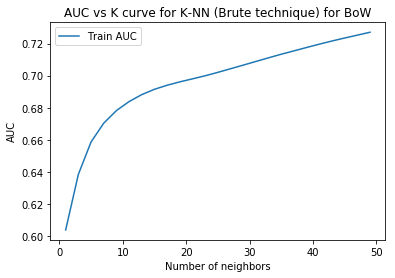

In [43]:
# Plot the AUC vs K curve
plt.title('AUC vs K curve for K-NN (Brute technique) for BoW')
plt.plot(neighbors,area_under_roc, label='Train AUC')
# plt.plot(neighbors, cv_scores, label='Train accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('AUC')
plt.show()

The optimal 'K' value is: 49
Accuracy on test set: 82.175%
Precision on test set: 0.837
Recall on test set: 0.973
F1-Score on test set: 0.899
Confusion Matrix of test set


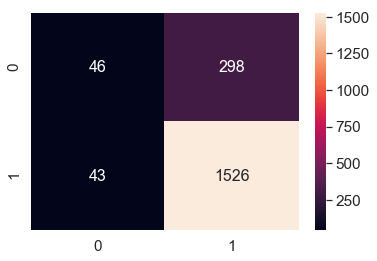

In [44]:
# ============================== KNN with k = optimal_k ===============================================
print("The optimal 'K' value is: {}".format(optimal_k))
knn_optimal = KNeighborsClassifier(n_neighbors=11, weights='distance', algorithm='brute')

# fitting the model
knn_optimal.fit(final_counts_train, y_train)

# predict the response
pred_proba = knn_optimal.predict_proba(final_counts_test)
pred = knn_optimal.predict(final_counts_test)

fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


No handles with labels found to put in legend.


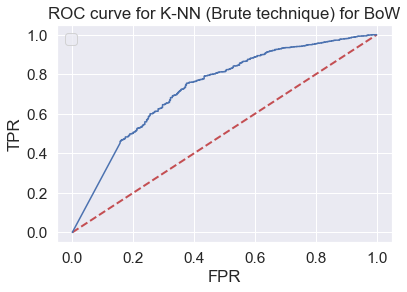

In [45]:
# Plot the ROC curve
plt.title('ROC curve for K-NN (Brute technique) for BoW')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
plt.plot(fpr, tpr, color='b')
# plt.plot(neighbors, cv_scores, label='Train accuracy')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Observation:
* The model is predicting minority class less accurately might be for imbalanced data, only 50 points are predicted as 0 out of 344 points

In [46]:
# Deleteing BoW vectors to clear memory
del final_counts_train
del final_counts_test

In [47]:
plt.close()

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [48]:
# Sparse to Dense matrix
final_tf_idf_train = final_tf_idf_train.toarray()
final_tf_idf_test = final_tf_idf_test.toarray()

Applying <b>PCA</b> to reduce the dimensionality for the ease of purpose

In [49]:
#*************** Reducing dimensions drastically due to memory issue
# Applying PCA to train so that we dont have to work with high dimensions
pca = decomposition.PCA(n_components=500)
final_tf_idf_train = pca.fit_transform(final_tf_idf_train)
final_tf_idf_test = pca.transform(final_tf_idf_test)
print("Train Data shape: ",final_tf_idf_train.shape)
print("Test Data shape: ",final_tf_idf_test.shape)

Train Data shape:  (7651, 500)
Test Data shape:  (1913, 500)


In [50]:
# Explaned variance
information = pca.explained_variance_ratio_.cumsum()
print("After Dimension reduction we retain {}% of information.".format(round(information[-1] * 100),2))

After Dimension reduction we retain 50.0% of information.


#### Applying KNN
* Taking a range of odd neighbours as this is a binary classification.
* We have used 10 fold cross validation
* The optimum 'K' is measured from the maximum value of AUC

In [51]:
s_time = time.time()
neighbors = list(range(1,50,2)) # Creating odd number of neighbors to get the optimal k
mean_fpr = np.linspace(0, 1, 100)
area_under_roc = []
tprs = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='brute')
    cv = StratifiedKFold(n_splits=10)
    for train, test in cv.split(final_tf_idf_train, y_train):
        proba = knn.fit(final_tf_idf_train[train], y_train[train]).predict_proba(final_tf_idf_train[test])
        fpr, tpr, thresholds = roc_curve(y_train[test], proba[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr)) # Calculation taken from sklearn auc documentation
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    area_under_roc.append(mean_auc)

optimal_k = neighbors[area_under_roc.index(max(area_under_roc))]
e_time = time.time()
print("The optimal 'K' value is: {}".format(optimal_k))
print("Total time taken: {}".format(e_time-s_time))

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:56<00:00,  2.30s/it]


The optimal 'K' value is: 49
Total time taken: 56.68290638923645


In [52]:
max(area_under_roc)

0.6600792329789413

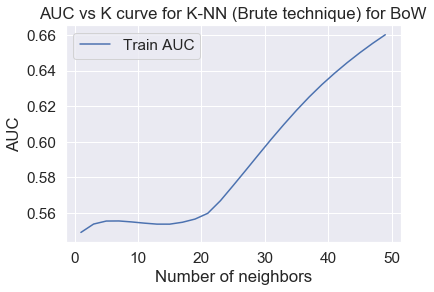

In [53]:
# Plot the AUC vs K curve
plt.title('AUC vs K curve for K-NN (Brute technique) for BoW')
plt.plot(neighbors,area_under_roc, label='Train AUC')
# plt.plot(neighbors, cv_scores, label='Train accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('AUC')
plt.show()

The optimal 'K' value is: 49
Accuracy on test set: 82.018%
Precision on test set: 0.821
Recall on test set: 0.999
F1-Score on test set: 0.901
Confusion Matrix of test set


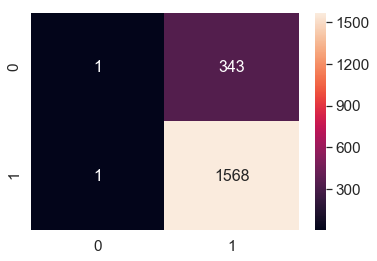

In [54]:
# ============================== KNN with k = optimal_k ===============================================
print("The optimal 'K' value is: {}".format(optimal_k))
knn_optimal = KNeighborsClassifier(n_neighbors=11, weights='distance', algorithm='brute')

# fitting the model
knn_optimal.fit(final_tf_idf_train, y_train)

# predict the response
pred_proba = knn_optimal.predict_proba(final_tf_idf_test)
pred = knn_optimal.predict(final_tf_idf_test)

fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


No handles with labels found to put in legend.


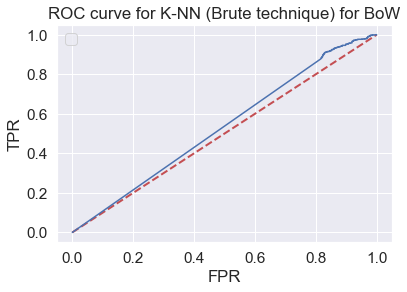

In [55]:
# Plot the ROC curve
plt.title('ROC curve for K-NN (Brute technique) for BoW')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
plt.plot(fpr, tpr, color='b')
# plt.plot(neighbors, cv_scores, label='Train accuracy')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Observation:
* The model is predicting minority class less accurately than the BoW implimentation.
* This could be because of imbalanced data and due to heavy information loss after using PCA
* The ROC curve is also very poor
* The Area Under ROC is is also very less only ~0.65

In [56]:
# Releasing memory
del final_tf_idf_train
del final_tf_idf_test
plt.close()

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

#### Applying KNN
* Taking a range of odd neighbours as this is a binary classification.
* We have used 10 fold cross validation
* The optimum 'K' is measured from the maximum value of AUC

In [75]:
s_time = time.time()
neighbors = list(range(1,50,2)) # Creating odd number of neighbors to get the optimal k
mean_fpr = np.linspace(0, 1, 100)
area_under_roc = []
tprs = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='brute')
    cv = StratifiedKFold(n_splits=10)
    for train, test in cv.split(sent_vectors_train, y_train):
        proba = knn.fit(np.array(sent_vectors_train)[train], y_train[train]).predict_proba(np.array(sent_vectors_train)[test])
        fpr, tpr, thresholds = roc_curve(y_train[test], proba[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr)) # Calculation taken from sklearn auc documentation
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    area_under_roc.append(mean_auc)

optimal_k = neighbors[area_under_roc.index(max(area_under_roc))]
e_time = time.time()
print("The optimal 'K' value is: {}".format(optimal_k))
print("Total time taken: {}".format(e_time-s_time))

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:15<00:00,  3.05s/it]


The optimal 'K' value is: 49
Total time taken: 75.40691256523132


In [76]:
max(area_under_roc)

0.6261753615454405

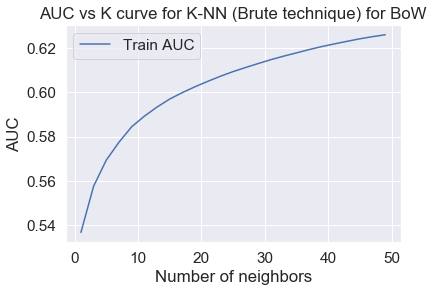

In [77]:
# Plot the AUC vs K curve
plt.title('AUC vs K curve for K-NN (Brute technique) for BoW')
plt.plot(neighbors,area_under_roc, label='Train AUC')
# plt.plot(neighbors, cv_scores, label='Train accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('AUC')
plt.show()

The optimal 'K' value is: 49
Accuracy on test set: 81.861%
Precision on test set: 0.825
Recall on test set: 0.989
F1-Score on test set: 0.899
Confusion Matrix of test set


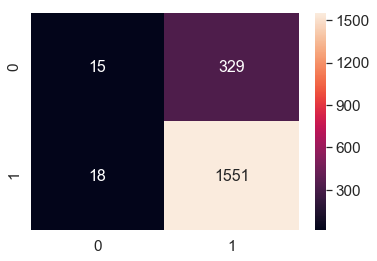

In [78]:
# ============================== KNN with k = optimal_k ===============================================
print("The optimal 'K' value is: {}".format(optimal_k))
knn_optimal = KNeighborsClassifier(n_neighbors=11, weights='distance', algorithm='brute')

# fitting the model
knn_optimal.fit(sent_vectors_train, y_train)

# predict the response
pred_proba = knn_optimal.predict_proba(sent_vectors_test)
pred = knn_optimal.predict(sent_vectors_test)

fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


No handles with labels found to put in legend.


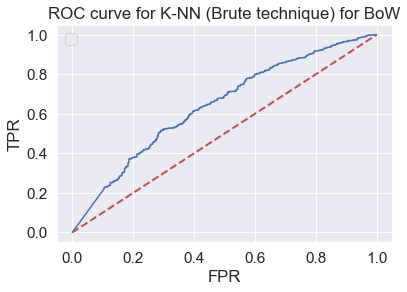

In [79]:
# Plot the ROC curve
plt.title('ROC curve for K-NN (Brute technique) for BoW')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
plt.plot(fpr, tpr, color='b')
# plt.plot(neighbors, cv_scores, label='Train accuracy')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Observation:
* The model is predicting minority class more accurately than the TFIDF implimentation but less than BoW implementation
* The ROC curve is no so good but better than TFIDF implimentation

In [80]:
# Releasing Memory
del sent_vectors_train
del sent_vectors_test
plt.close()

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

#### Applying KNN
* Taking a range of odd neighbours as this is a binary classification.
* We have used 10 fold cross validation
* The optimum 'K' is measured from the maximum value of AUC

In [82]:
s_time = time.time()
neighbors = list(range(1,50,2)) # Creating odd number of neighbors to get the optimal k
mean_fpr = np.linspace(0, 1, 100)
area_under_roc = []
tprs = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='brute')
    cv = StratifiedKFold(n_splits=10)
    for train, test in cv.split(tfidf_sent_vectors_train, y_train):
        proba = knn.fit(np.array(tfidf_sent_vectors_train)[train], y_train[train]).predict_proba(np.array(tfidf_sent_vectors_train)[test])
        fpr, tpr, thresholds = roc_curve(y_train[test], proba[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr)) # Calculation taken from sklearn auc documentation
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    area_under_roc.append(mean_auc)

optimal_k = neighbors[area_under_roc.index(max(area_under_roc))]
e_time = time.time()
print("The optimal 'K' value is: {}".format(optimal_k))
print("Total time taken: {}".format(e_time-s_time))

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:15<00:00,  3.07s/it]


The optimal 'K' value is: 49
Total time taken: 75.98028993606567


In [83]:
max(area_under_roc)

0.5973152623812986

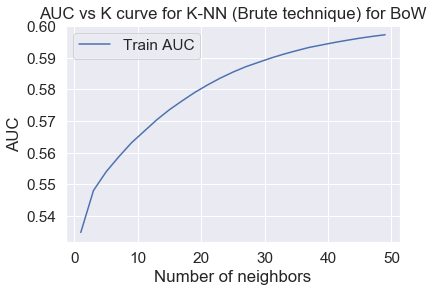

In [84]:
# Plot the AUC vs K curve
plt.title('AUC vs K curve for K-NN (Brute technique) for BoW')
plt.plot(neighbors,area_under_roc, label='Train AUC')
# plt.plot(neighbors, cv_scores, label='Train accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('AUC')
plt.show()

The optimal 'K' value is: 49
Accuracy on test set: 81.704%
Precision on test set: 0.823
Recall on test set: 0.989
F1-Score on test set: 0.899
Confusion Matrix of test set


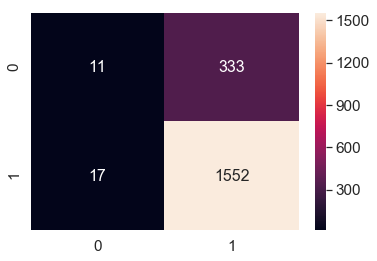

In [85]:
# ============================== KNN with k = optimal_k ===============================================
print("The optimal 'K' value is: {}".format(optimal_k))
knn_optimal = KNeighborsClassifier(n_neighbors=11, weights='distance', algorithm='brute')

# fitting the model
knn_optimal.fit(tfidf_sent_vectors_train, y_train)

# predict the response
pred_proba = knn_optimal.predict_proba(tfidf_sent_vectors_test)
pred = knn_optimal.predict(tfidf_sent_vectors_test)

fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


No handles with labels found to put in legend.


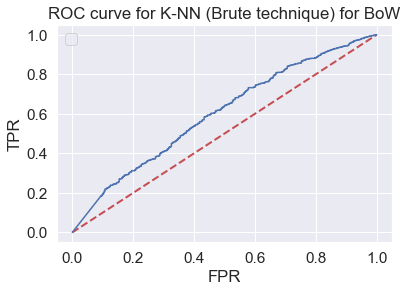

In [86]:
# Plot the ROC curve
plt.title('ROC curve for K-NN (Brute technique) for BoW')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
plt.plot(fpr, tpr, color='b')
# plt.plot(neighbors, cv_scores, label='Train accuracy')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Observation:
* The model is predicting minority class more accurately than the TFIDF implimentation but less than BoW and avg-W2vec implementation
* The ROC curve is no so good but better than TFIDF implimentation

In [87]:
# Releasing Memory
del tfidf_sent_vectors_train
del tfidf_sent_vectors_test
plt.close()

## [5.2] Applying KNN kd-tree

### Unpickle the files before processing

In [129]:
import pickle

bow_train = 'bow_train.pkl'
bow_test = 'bow_test.pkl'
tfidf_train = 'tfidf_train.pkl'
tfidf_test = 'tfidf_test.pkl'
avgw2v_train = 'avgw2v_train.pkl'
avgw2v_test = 'avgw2v_test.pkl'
tfidfw2v_train = 'tfidfw2v_train.pkl'
tfidfw2v_test = 'tfidfw2v_test.pkl'

obj1 = open(bow_train,'rb')
final_counts_train = pickle.load(obj1)
obj1.close()

obj2 = open(bow_test,'rb')
final_counts_test = pickle.load(obj2)
obj2.close()

obj3 = open(tfidf_train,'rb')
final_tf_idf_train = pickle.load(obj3)
obj3.close()

obj4 = open(tfidf_test,'rb')
final_tf_idf_test = pickle.load(obj4)
obj4.close()

obj5 = open(avgw2v_train,'rb')
sent_vectors_train = pickle.load(obj5)
obj5.close()

obj6 = open(avgw2v_test,'rb')
sent_vectors_test = pickle.load(obj6)
obj6.close()

obj7 = open(tfidfw2v_train,'rb')
tfidf_sent_vectors_train = pickle.load(obj7)
obj7.close()

obj8 = open(tfidfw2v_test,'rb')
tfidf_sent_vectors_test = pickle.load(obj8)
obj8.close()

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [130]:
# Sparse to Dense matrix
final_counts_train = final_counts_train.toarray()
final_counts_test = final_counts_test.toarray()

Applying <b>PCA</b> to reduce the dimensionality for the ease of purpose

In [131]:
#*************** Reducing dimensions drastically due to memory issue
# Applying PCA to train so that we dont have to work with high dimensions
pca = decomposition.PCA(n_components=500)
final_counts_train = pca.fit_transform(final_counts_train)
final_counts_test = pca.transform(final_counts_test)
print("Train Data shape: ",final_counts_train.shape)
print("Test Data shape: ",final_counts_test.shape)

Train Data shape:  (7651, 500)
Test Data shape:  (1913, 500)


In [132]:
# Explaned variance
information = pca.explained_variance_ratio_.cumsum()
print("After Dimension reduction we retain {}% of information.".format(round(information[-1] * 100),2))

After Dimension reduction we retain 75.0% of information.


#### Applying KNN
* Taking a range of odd neighbours as this is a binary classification.
* We have used 10 fold cross validation
* The optimum 'K' is measured from the maximum value of AUC

In [133]:
s_time = time.time()
neighbors = list(range(1,50,2)) # Creating odd number of neighbors to get the optimal k
mean_fpr = np.linspace(0, 1, 100)
area_under_roc = []
tprs = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='kd_tree')
    cv = StratifiedKFold(n_splits=10)
    for train, test in cv.split(final_counts_train, y_train):
        proba = knn.fit(final_counts_train[train], y_train[train]).predict_proba(final_counts_train[test])
        fpr, tpr, thresholds = roc_curve(y_train[test], proba[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr)) # Calculation taken from sklearn auc documentation
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    area_under_roc.append(mean_auc)

optimal_k = neighbors[area_under_roc.index(max(area_under_roc))]
e_time = time.time()
print("The optimal 'K' value is: {}".format(optimal_k))
print("Total time taken: {}".format(e_time-s_time))

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [29:06<00:00, 70.04s/it]


The optimal 'K' value is: 49
Total time taken: 1746.7794513702393


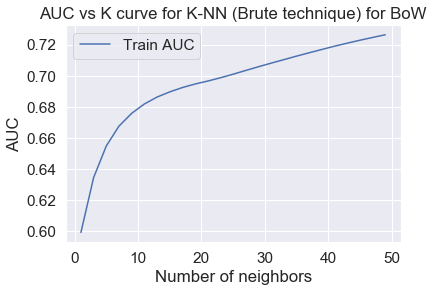

In [134]:
# Plot the AUC vs K curve
plt.title('AUC vs K curve for K-NN (Brute technique) for BoW')
plt.plot(neighbors,area_under_roc, label='Train AUC')
# plt.plot(neighbors, cv_scores, label='Train accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('AUC')
plt.show()

The optimal 'K' value is: 49
Accuracy on test set: 82.122%
Precision on test set: 0.838
Recall on test set: 0.970
F1-Score on test set: 0.899
Confusion Matrix of test set


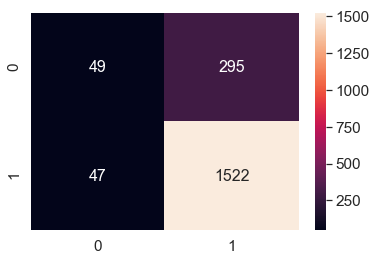

In [135]:
# ============================== KNN with k = optimal_k ===============================================
print("The optimal 'K' value is: {}".format(optimal_k))
knn_optimal = KNeighborsClassifier(n_neighbors=11, weights='distance', algorithm='kd_tree')

# fitting the model
knn_optimal.fit(final_counts_train, y_train)

# predict the response
pred_proba = knn_optimal.predict_proba(final_counts_test)
pred = knn_optimal.predict(final_counts_test)

fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


No handles with labels found to put in legend.


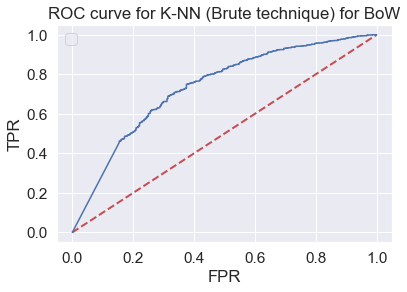

In [136]:
# Plot the ROC curve
plt.title('ROC curve for K-NN (Brute technique) for BoW')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
plt.plot(fpr, tpr, color='b')
# plt.plot(neighbors, cv_scores, label='Train accuracy')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Observation:
* The model is predicting minority class less accurately might be for imbalanced data, only 50 points are predicted as 0 out of 344 points which is almost same as the BoW implimentation for Bruit version

In [137]:
# Deleteing BoW vectors to clear memory
del final_counts_train
del final_counts_test

In [138]:
plt.close()

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [139]:
# Sparse to Dense matrix
final_tf_idf_train = final_tf_idf_train.toarray()
final_tf_idf_test = final_tf_idf_test.toarray()

Applying <b>PCA</b> to reduce the dimensionality for the ease of purpose

In [140]:
#*************** Reducing dimensions drastically due to memory issue
# Applying PCA to train so that we dont have to work with high dimensions
pca = decomposition.PCA(n_components=500)
final_tf_idf_train = pca.fit_transform(final_tf_idf_train)
final_tf_idf_test = pca.transform(final_tf_idf_test)
print("Train Data shape: ",final_tf_idf_train.shape)
print("Test Data shape: ",final_tf_idf_test.shape)

Train Data shape:  (7651, 500)
Test Data shape:  (1913, 500)


In [141]:
# Explaned variance
information = pca.explained_variance_ratio_.cumsum()
print("After Dimension reduction we retain {}% of information.".format(round(information[-1] * 100),2))

After Dimension reduction we retain 50.0% of information.


#### Applying KNN
* Taking a range of odd neighbours as this is a binary classification.
* We have used 10 fold cross validation
* The optimum 'K' is measured from the maximum value of AUC

In [142]:
s_time = time.time()
neighbors = list(range(1,50,2)) # Creating odd number of neighbors to get the optimal k
mean_fpr = np.linspace(0, 1, 100)
area_under_roc = []
tprs = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='kd_tree')
    cv = StratifiedKFold(n_splits=10)
    for train, test in cv.split(final_tf_idf_train, y_train):
        proba = knn.fit(final_tf_idf_train[train], y_train[train]).predict_proba(final_tf_idf_train[test])
        fpr, tpr, thresholds = roc_curve(y_train[test], proba[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr)) # Calculation taken from sklearn auc documentation
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    area_under_roc.append(mean_auc)

optimal_k = neighbors[area_under_roc.index(max(area_under_roc))]
e_time = time.time()
print("The optimal 'K' value is: {}".format(optimal_k))
print("Total time taken: {}".format(e_time-s_time))

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [17:28<00:00, 41.79s/it]


The optimal 'K' value is: 49
Total time taken: 1048.433676481247


In [143]:
max(area_under_roc)

0.6614024998018956

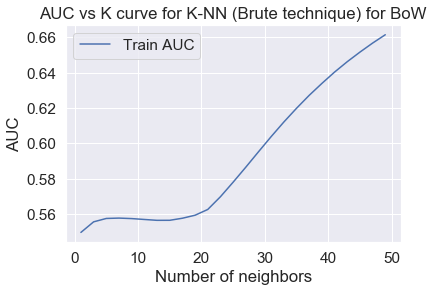

In [144]:
# Plot the AUC vs K curve
plt.title('AUC vs K curve for K-NN (Brute technique) for BoW')
plt.plot(neighbors,area_under_roc, label='Train AUC')
# plt.plot(neighbors, cv_scores, label='Train accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('AUC')
plt.show()

The optimal 'K' value is: 49
Accuracy on test set: 82.018%
Precision on test set: 0.821
Recall on test set: 0.999
F1-Score on test set: 0.901
Confusion Matrix of test set


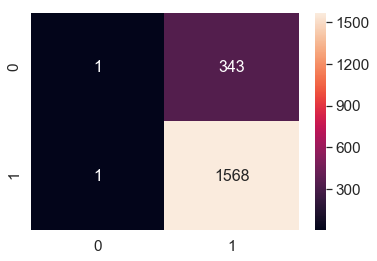

In [145]:
# ============================== KNN with k = optimal_k ===============================================
print("The optimal 'K' value is: {}".format(optimal_k))
knn_optimal = KNeighborsClassifier(n_neighbors=11, weights='distance', algorithm='kd_tree')

# fitting the model
knn_optimal.fit(final_tf_idf_train, y_train)

# predict the response
pred_proba = knn_optimal.predict_proba(final_tf_idf_test)
pred = knn_optimal.predict(final_tf_idf_test)

fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


No handles with labels found to put in legend.


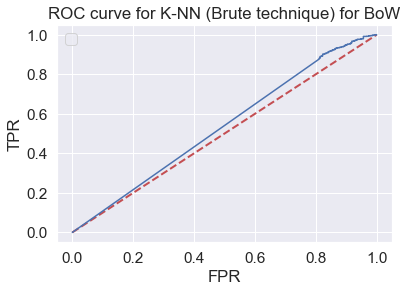

In [146]:
# Plot the ROC curve
plt.title('ROC curve for K-NN (Brute technique) for BoW')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
plt.plot(fpr, tpr, color='b')
# plt.plot(neighbors, cv_scores, label='Train accuracy')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Observation:
* The model is predicting minority class less accurately than the BoW implimentation.
* This could be because of imbalanced data and due to heavy information loss after using PCA
* The ROC curve is also very poor
* The Area Under ROC is is also very less only ~0.65

In [147]:
# Releasing memory
del final_tf_idf_train
del final_tf_idf_test
plt.close()

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 7</font>

#### Applying KNN
* Taking a range of odd neighbours as this is a binary classification.
* We have used 10 fold cross validation
* The optimum 'K' is measured from the maximum value of AUC

In [148]:
s_time = time.time()
neighbors = list(range(1,50,2)) # Creating odd number of neighbors to get the optimal k
mean_fpr = np.linspace(0, 1, 100)
area_under_roc = []
tprs = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='kd_tree')
    cv = StratifiedKFold(n_splits=10)
    for train, test in cv.split(sent_vectors_train, y_train):
        proba = knn.fit(np.array(sent_vectors_train)[train], y_train[train]).predict_proba(np.array(sent_vectors_train)[test])
        fpr, tpr, thresholds = roc_curve(y_train[test], proba[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr)) # Calculation taken from sklearn auc documentation
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    area_under_roc.append(mean_auc)

optimal_k = neighbors[area_under_roc.index(max(area_under_roc))]
e_time = time.time()
print("The optimal 'K' value is: {}".format(optimal_k))
print("Total time taken: {}".format(e_time-s_time))

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [08:18<00:00, 22.88s/it]


The optimal 'K' value is: 49
Total time taken: 498.9596140384674


In [149]:
max(area_under_roc)

0.6268779693836735

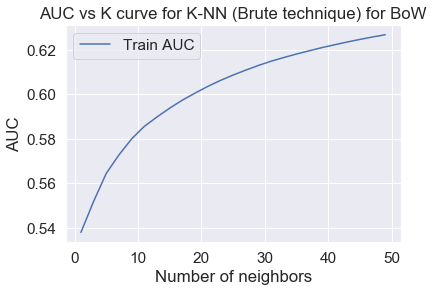

In [150]:
# Plot the AUC vs K curve
plt.title('AUC vs K curve for K-NN (Brute technique) for BoW')
plt.plot(neighbors,area_under_roc, label='Train AUC')
# plt.plot(neighbors, cv_scores, label='Train accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('AUC')
plt.show()

The optimal 'K' value is: 49
Accuracy on test set: 82.070%
Precision on test set: 0.825
Recall on test set: 0.992
F1-Score on test set: 0.901
Confusion Matrix of test set


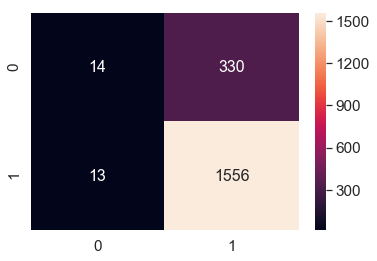

In [151]:
# ============================== KNN with k = optimal_k ===============================================
print("The optimal 'K' value is: {}".format(optimal_k))
knn_optimal = KNeighborsClassifier(n_neighbors=11, weights='distance', algorithm='kd_tree')

# fitting the model
knn_optimal.fit(sent_vectors_train, y_train)

# predict the response
pred_proba = knn_optimal.predict_proba(sent_vectors_test)
pred = knn_optimal.predict(sent_vectors_test)

fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


No handles with labels found to put in legend.


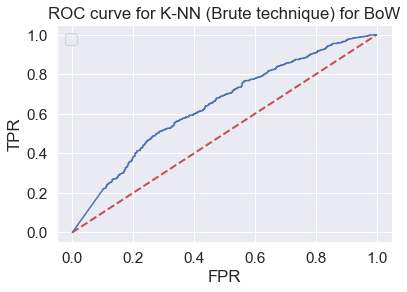

In [152]:
# Plot the ROC curve
plt.title('ROC curve for K-NN (Brute technique) for BoW')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
plt.plot(fpr, tpr, color='b')
# plt.plot(neighbors, cv_scores, label='Train accuracy')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Observation:
* The model is predicting minority class more accurately than the TFIDF implimentation but less than BoW implementation
* The ROC curve is no so good but better than TFIDF implimentation

In [153]:
# Releasing Memory
del sent_vectors_train
del sent_vectors_test
plt.close()

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 8</font>

#### Applying KNN
* Taking a range of odd neighbours as this is a binary classification.
* We have used 10 fold cross validation
* The optimum 'K' is measured from the maximum value of AUC

In [154]:
s_time = time.time()
neighbors = list(range(1,50,2)) # Creating odd number of neighbors to get the optimal k
mean_fpr = np.linspace(0, 1, 100)
area_under_roc = []
tprs = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='kd_tree')
    cv = StratifiedKFold(n_splits=10)
    for train, test in cv.split(tfidf_sent_vectors_train, y_train):
        proba = knn.fit(np.array(tfidf_sent_vectors_train)[train], y_train[train]).predict_proba(np.array(tfidf_sent_vectors_train)[test])
        fpr, tpr, thresholds = roc_curve(y_train[test], proba[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr)) # Calculation taken from sklearn auc documentation
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    area_under_roc.append(mean_auc)

optimal_k = neighbors[area_under_roc.index(max(area_under_roc))]
e_time = time.time()
print("The optimal 'K' value is: {}".format(optimal_k))
print("Total time taken: {}".format(e_time-s_time))

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [07:18<00:00, 20.15s/it]


The optimal 'K' value is: 49
Total time taken: 438.3280396461487


In [155]:
max(area_under_roc)

0.598104257807491

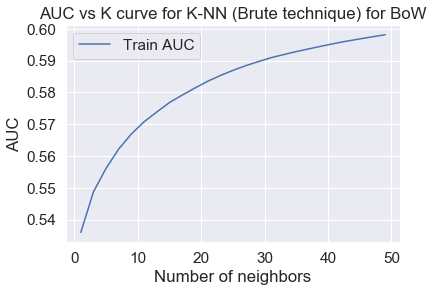

In [156]:
# Plot the AUC vs K curve
plt.title('AUC vs K curve for K-NN (Brute technique) for BoW')
plt.plot(neighbors,area_under_roc, label='Train AUC')
# plt.plot(neighbors, cv_scores, label='Train accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('AUC')
plt.show()

The optimal 'K' value is: 49
Accuracy on test set: 81.913%
Precision on test set: 0.825
Recall on test set: 0.990
F1-Score on test set: 0.900
Confusion Matrix of test set


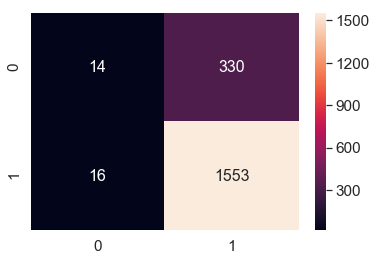

In [157]:
# ============================== KNN with k = optimal_k ===============================================
print("The optimal 'K' value is: {}".format(optimal_k))
knn_optimal = KNeighborsClassifier(n_neighbors=11, weights='distance', algorithm='kd_tree')

# fitting the model
knn_optimal.fit(tfidf_sent_vectors_train, y_train)

# predict the response
pred_proba = knn_optimal.predict_proba(tfidf_sent_vectors_test)
pred = knn_optimal.predict(tfidf_sent_vectors_test)

fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
# evaluate accuracy
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, pred)))
print("Confusion Matrix of test set")
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)
# Concept of heat map on confusion matrix and accuracy scores taken from : https://github.com/cyanamous/Amazon-Food-Reviews-Analysis-and-Modelling/blob/master/2%20Amazon%20Food%20Reviews%20-%20KNN%20.ipynb
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


No handles with labels found to put in legend.


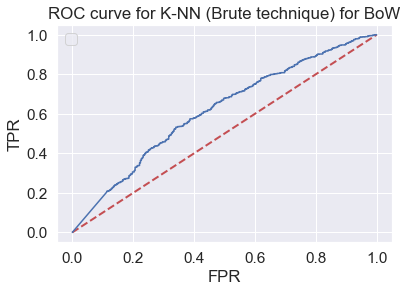

In [158]:
# Plot the ROC curve
plt.title('ROC curve for K-NN (Brute technique) for BoW')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
plt.plot(fpr, tpr, color='b')
# plt.plot(neighbors, cv_scores, label='Train accuracy')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Observation:
* The model is predicting minority class more accurately than the TFIDF implimentation but less than BoW and avg-W2vec implementation
* The ROC curve is no so good but better than TFIDF implimentation

In [159]:
# Releasing Memory
del tfidf_sent_vectors_train
del tfidf_sent_vectors_test
plt.close()

# [6] Conclusions

In [160]:
from prettytable import PrettyTable

In [165]:
x = PrettyTable()

x.field_names = ["Vectorizer", "Algorithm", "Hyper Parameter", "AUC", "Accuracy", "Precision", "Recall", "F1 Score"]

x.add_row(["BoW", "Brute", 49, .729, "82.175%", 0.837, 0.973, 0.899])
x.add_row(["TFIDF", "Brute", 49, .651, "82.018%", 0.821, 0.999, 0.901])
x.add_row(["Avg-W2Vec", "Brute", 49, .626, "81.861%", 0.825, 0.989, 0.899])
x.add_row(["TFIDF W2Vec", "Brute", 49, .597, "81.704%", 0.823, 0.989, 0.899])
x.add_row(["BoW", "KDTREE", 49, .729, "82.122%", 0.838, 0.970, 0.899])
x.add_row(["TFIDF", "KDTREE", 49, .661, "82.018%", 0.821, 0.901, 0.999])
x.add_row(["Avg-W2Vec", "KDTREE", 49, .626, "82.070%", 0.825, 0.992, 0.901])
x.add_row(["TFIDF W2Vec", "KDTREE", 49, .598, "81.913%", 0.825, 0.990, 0.900])

print(x)

+-------------+-----------+-----------------+-------+----------+-----------+--------+----------+
|  Vectorizer | Algorithm | Hyper Parameter |  AUC  | Accuracy | Precision | Recall | F1 Score |
+-------------+-----------+-----------------+-------+----------+-----------+--------+----------+
|     BoW     |   Brute   |        49       | 0.729 | 82.175%  |   0.837   | 0.973  |  0.899   |
|    TFIDF    |   Brute   |        49       | 0.651 | 82.018%  |   0.821   | 0.999  |  0.901   |
|  Avg-W2Vec  |   Brute   |        49       | 0.626 | 81.861%  |   0.825   | 0.989  |  0.899   |
| TFIDF W2Vec |   Brute   |        49       | 0.597 | 81.704%  |   0.823   | 0.989  |  0.899   |
|     BoW     |   KDTREE  |        49       | 0.729 | 82.122%  |   0.838   |  0.97  |  0.899   |
|    TFIDF    |   KDTREE  |        49       | 0.661 | 82.018%  |   0.821   | 0.901  |  0.999   |
|  Avg-W2Vec  |   KDTREE  |        49       | 0.626 | 82.070%  |   0.825   | 0.992  |  0.901   |
| TFIDF W2Vec |   KDTREE  |   

### Overall Observation
* KNN is timetaking and memory inefficient method for predicting data
* Due to this we have used very less amount of data as well as PCA to recude dimensions drastically leading to information loss
* In this case the average acuracy stands on ~82%
* The average AUC is ~0.67
* From the table above we can conclude that, from the AUC and accuracy measure BoW with Brute algorithm suits the best